# PanCheck PoC

In [1]:
import os
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Reading GFA

In [2]:
with open("pan1c.08SC-test.gfa", "r") as handle:
    GFA = [line.rstrip() for line in handle.readlines()]
print(GFA[:10])

['H\tVN:Z:1.0', '#\tThis graph have been created using the Pan1c workflow (https://forgemia.inra.fr/alexis.mergez/pan1c)', '#', '#\tTool versions and commands', '#', '#\t-- Pan1c --', '#\tPan1c\tpan1c.version: v1.12a-93-gba2cbe5', '#\tPan1c\tpan1c.home: https://forgemia.inra.fr/alexis.mergez/pan1c', "#\tPan1c\tname: '08SC-test'", "#\tPan1c\treference: 'R64.hap1.fa.gz'"]


## Searching unique nodes

In [3]:
NODES = {} # <Node_id> : {LEN: <Length>, PATHS: <list of traversed path>}
PATHS = {} # <Path_id> : {SET: <node_ids ensemble>, LIST: <node_ids list>, LEN: <path length>}

for line in GFA:
    s_line = line.split('\t') # Splitting line
    if s_line[0] == 'S': 
        NODES[int(s_line[1])] = {"LEN": len(s_line[2]), "PATHS": []}
    if s_line[0] == 'P':
        tmp = [int(node[:-1]) for node in s_line[2].split(",")]
        PATHS[str(s_line[1])] = {
            "SET": set(tmp),
            "LIST": tmp
        }

# Computing path length
for path in PATHS.keys():
    length = 0
    for node_id in PATHS[path]["LIST"]:
        length += NODES[node_id]["LEN"]
    PATHS[path]["LEN"] = length

# Searching unique nodes by paths
UpNODES = {"SAMPLE": [], "PATH": [], "LEN": [], "PROP": []}
for node in NODES.keys():
    count = 0

    # Checking if present in each path
    for path in PATHS.keys():
        if node in PATHS[path]["SET"] : 
            count += 1
            NODES[node]["PATHS"].append(path)

    if count == 1:
        UpNODES["PATH"].append(NODES[node]["PATHS"][0]) # Path
        UpNODES["SAMPLE"].append("#".join(NODES[node]["PATHS"][0].split("#")[:2])) # Sample
        UpNODES["LEN"].append(NODES[node]["LEN"]) # Length
        UpNODES["PROP"].append((NODES[node]["LEN"]/PATHS[NODES[node]["PATHS"][0]]["LEN"])*100) # Proportion compared to whole path

data = pd.DataFrame.from_dict(UpNODES)
data.describe()

LEN           PROP
count  199970.000000  199970.000000
mean       13.740876       0.002227
std       301.329333       0.050181
min         1.000000       0.000065
25%         1.000000       0.000094
50%         1.000000       0.000127
75%         1.000000       0.000220
max     42792.000000       6.099981

## Plotting density

In [4]:
dataG = data.groupby(["SAMPLE", "PATH"]).sum().reset_index().drop("PATH", axis = 1)
mean_prop = dataG.groupby("SAMPLE")["PROP"].mean()
dataG['MEAN_PROP'] = dataG['SAMPLE'].map(mean_prop)
dataG

SAMPLE    LEN      PROP  MEAN_PROP
0    BJ4#1  10617  4.702823   4.096090
1    BJ4#1  40915  5.013387   4.096090
2    BJ4#1  17309  5.540848   4.096090
3    BJ4#1  46229  3.104589   4.096090
4    BJ4#1  25331  4.444729   4.096090
..     ...    ...       ...        ...
131  Y55#1  26151  2.852530   3.742652
132  Y55#1   4422  0.579111   3.742652
133  Y55#1  24370  2.307191   3.742652
134  Y55#1  27325  2.983036   3.742652
135  Y55#1   6684  8.267468   3.742652

[136 rows x 4 columns]

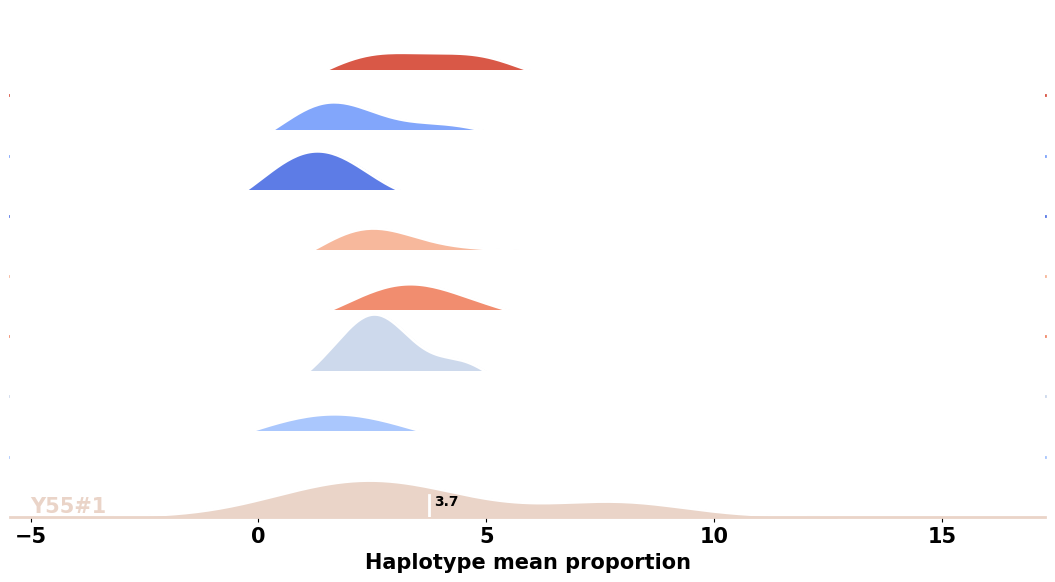

In [5]:
# we generate a color palette with Seaborn.color_palette()
pal = sns.color_palette(palette='coolwarm', n_colors=len(data["SAMPLE"].unique()))

# in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
g = sns.FacetGrid(dataG, row="SAMPLE", hue='MEAN_PROP', aspect=15, height=0.75, palette=pal)

# then we add the densities kdeplots for each SAMPLE
g.map(sns.kdeplot, 'PROP',
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

# here we add a white line that represents the contour of each kdeplot
g.map(sns.kdeplot, 'PROP', 
      bw_adjust=1, clip_on=False, 
      color="w", lw=2)

# here we add a horizontal line for each plot
g.map(plt.axhline, y=0,
      lw=2, clip_on=False)

# we loop over the FacetGrid figure axes (g.axes.flat) and add the month as text with the right color
# notice how ax.lines[-1].get_color() enables you to access the last line's color in each matplotlib.Axes
for i, ax in enumerate(g.axes.flat):
    ax.text(-5, 0.02, dataG["SAMPLE"].unique()[i],
            fontweight='bold', fontsize=15,
            color=ax.lines[-1].get_color())
    ax.axvline(mean_prop[dataG["SAMPLE"].unique()[i]], ymax=0.25, ymin=0, lw=2, color="white")
    ax.text(mean_prop[dataG["SAMPLE"].unique()[i]]+.1, 0.05, str(round(mean_prop[dataG["SAMPLE"].unique()[i]], 1)),
            fontweight='bold', fontsize=10)
    
# we use matplotlib.Figure.subplots_adjust() function to get the subplots to overlap
g.fig.subplots_adjust(hspace=-0.3)

# eventually we remove axes titles, yticks and spines
g.set_titles("")
g.set(yticks=[])
g.set(ylabel=None)
g.despine(bottom=True, left=True)

plt.setp(ax.get_xticklabels(), fontsize=15, fontweight='bold')
plt.xlabel('Haplotype mean proportion', fontweight='bold', fontsize=15)

plt.show()